<a href="https://colab.research.google.com/github/TL-SD/ML-2019-assignments/blob/master/Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group
Fanxing Meng-13116746
Tao Liu-13063781

#Introduction





  Nowadays, with the development of IT technology, a large number of e-commerce websites have emerged, such as Alibaba, Amazon, Ebay and platforms providing other services such as Uber, Uber eats, etc. These new platforms combine traditional service industry with IT technology which has changed the way people live. 
Generally speaking, consumers often give their reviews and rating about services on these platforms. The reviews provided by users can help other customers with their decision, as well as provide important business information for the merchants for future improvement, so it is very meaningful for both customers and companies.
E-commerce platforms often have a large number of reviews. It is impossible for enterprise managers analyze them one by one. Therefore, using machine learning to convert human language into machine-recognizable language, then providing statistical analysis of the result, can transfer the messy data into useful information efficiently.
In this project, the data set we selected is the reviews provided by customers who purchased the mobile phone on Amazon. We first browsed the dataset to understand it, then chose the appropriate method for data preprocessing. After that we established models for converting the text into machine-recognizable data, and the classification algorithms would be used to construct the classifier models, so that the text reviews can be quickly converted into a quantifiable measurement index. Finally, we briefly summarized the experimental results and discussed the issues from an ethical perspective.


# Exploration


  The dataset we used was extracted by PromptCloud, which contains 400 thousand reviews of mobile phones sold on Amazon.com.

In [0]:
#import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

In [0]:
from google.colab import auth
auth.authenticate_user()

!pip install -U -q Pydrive
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

data = drive.CreateFile({'id':'1URg7XAee9alf6zwfZ902S0sxXy54IjE5'})
data.GetContentFile('Amazon_Mobile.csv')

In [0]:
data_file = 'Amazon_Mobile.csv'
dataset = pd.read_csv(data_file)
dataset.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


From the dataframe we can see it contains 6 conlumns, to solve the problem we take 'Rating' and 'Reviews' column as our main focus, thus we use 'describe' method to analyze the statistics of the dataset. 

In [0]:
dataset.groupby('Rating').describe()

Price                                ... Review Votes                 
           count        mean         std   min  ...          25%  50%  75%    max
Rating                                          ...                              
1        70922.0  202.234424  239.149267  1.73  ...          0.0  0.0  2.0  645.0
2        24263.0  194.069618  258.757304  1.73  ...          0.0  0.0  1.0  478.0
3        31169.0  185.621979  250.625445  1.73  ...          0.0  0.0  1.0  428.0
4        60540.0  211.567870  277.644488  1.73  ...          0.0  0.0  1.0  350.0
5       221013.0  248.379731  284.259249  1.73  ...          0.0  0.0  1.0  524.0

[5 rows x 16 columns]

In [0]:
#check null value
dataset['Rating'].isnull().any()

False

In [0]:
dataset['Reviews'].head(30)

0     I feel so LUCKY to have found this used (phone...
1     nice phone, nice up grade from my pantach revu...
2                                          Very pleased
3     It works good but it goes slow sometimes but i...
4     Great phone to replace my lost phone. The only...
5     I already had a phone with problems... I know ...
6     The charging port was loose. I got that solder...
7     Phone looks good but wouldn't stay charged, ha...
8     I originally was using the Samsung S2 Galaxy f...
9     It's battery life is great. It's very responsi...
10    My fiance had this phone previously, but cause...
11    This is a great product it came after two days...
12    These guys are the best! I had a little situat...
13    I'm really disappointed about my phone and ser...
14    Ordered this phone as a replacement for the sa...
15    Had this phone before and loved it but was not...
16    I was able to get the phone I previously owned...
17    I brought this phone as a replacement for 

In [0]:
lens = dataset.Reviews.str.len()
lens.mean(), lens.std(), lens.max()

(216.70659145725486, 463.6001022601651, 29419.0)

From the attributes shown above, the reviews in the dataset contains a lot of meaningless words. To use NLP we need to clean the texts and remove them.

Visualize attributes

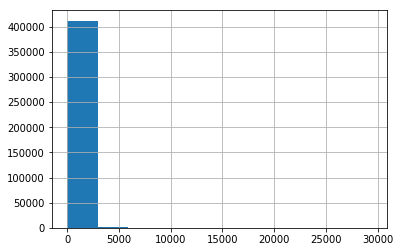

In [0]:
lens.hist();

In [0]:
dataset.shape

(413840, 6)

In [0]:
ratings = dataset['Rating'].value_counts()

label_rating = ratings.index
size_rating = ratings.values

colors = ['pink', 'blue', 'yellow', 'gold', 'crimson']

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         marker = dict(colors = colors),
                         name = 'unlocked phone', hole = 0.3)

df = [rating_piechart]

layout = go.Layout(
           title = 'Distribution of Ratings')

fig = go.Figure(data = df,
                 layout = layout)

py.iplot(fig)

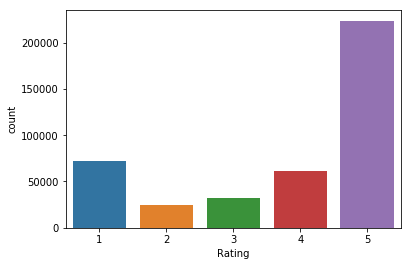

In [0]:
sns.countplot(dataset['Rating'])

In [0]:
n = 413840  
s = 30000
skip = sorted(random.sample(range(1,n),n-s))


dataset = pd.read_csv( data_file, delimiter = ",", skiprows = skip)

In [0]:
dataset.shape

(30000, 6)

As can be seen from the above exploration, this dataset has a total of 413,840 data. In order to speed up the construction of the model, we randomly selected 30,000 of them to generate a new dataframe for modeling. Our goal is to classify all the comments into 5 ratings by building the classifier, so we mainly use the two columns ‘Reviews’ and Rating.

In order to convert the text into a machine-recognizable form, we need to find suitable models for the preprocessing. At the same time, from the above dataset, we find that the text contains irregular forms such as capitalization, tense, and symbols, so we will normalize them for reducing the computational complexity of the model and increase the accuracy of the model.

From the statistics we found that the data set does not contain the missing value, so no processing about that is required.
At the same time, we need to build a classifier model from the requirements. From the dataset, we can see that the scores are mainly divided into 5 categories from 1 to 5, so we need to build a multi-classifier to classify the processed text. At the same time, it can be seen that the number of characters in the comments have large difference from long to short, so it is necessary to select a classification model suitable for the text with various lengths. According to the online research, there are several models perform well for dealing this kind of classification, including Random Forest model, NBSVM model and LSTM neural network. Therefore, we plan to build the above three models and train them. 
We will select 70% of the data from the dataset as the training dataset, and the remaining 30% as the test dataset, then compare the predicted classification result with the test sample to evaluate the accuracy of the model.



#Methodology

Firstly, we build the NLP model.
NLP is a way for computers to analyze, understand, and derive meaning from human language in a smart and useful way. By utilizing NLP, developers can organize and structure knowledge to perform tasks such as automatic summarization, translation, named entity recognition, relationship extraction, sentiment analysis, speech recognition, and topic segmentation.
In our case, we build natural language process to transfer all the reviews to an array.

We use the NLTK library from NLP model to process the randomly selected 30,000 text comments, by converting all uppercase to lowercase, removing meaningless words, converting words to space-separated arrays, and extracting text using the countVectorizer library. Then we use the frequency of words to determine the feature of reviews. 

In [0]:
#clean the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 30000): 
    review = re.sub('[^a-zA-Z]', ' ', str(dataset['Reviews'] [i]))
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Creat the bag of words model.
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(corpus).toarray()

In [0]:
X.shape

(30000, 2500)

In [0]:
y = dataset.iloc[:,3].values

In [0]:
#split dataset into Training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 15)

Then we build a random forest model. The processed text is divided into two parts, train and test, with a ratio of 0.3. We use the random forest classifier in the sklearn library, set the number of decision trees to 100, then import the data set into the model for model training, finally compare the prediction results with the real results.

In [0]:
#Implement random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#evaluate the prediction result
print("Training Accuracy :", model.score(X_train, y_train))
print("Testing Accuracy :", model.score(X_test, y_test))

cm_randomforest = confusion_matrix(y_test, y_pred)
print(cm_randomforest)

Training Accuracy : 0.9667142857142857
Testing Accuracy : 0.7067777777777777
[[1272   16   18   22  218]
 [ 292   64   19   21  154]
 [ 205    4  127   53  294]
 [ 122    6   13  210  951]
 [ 142    6   12   71 4688]]


In [0]:
# visualization function
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

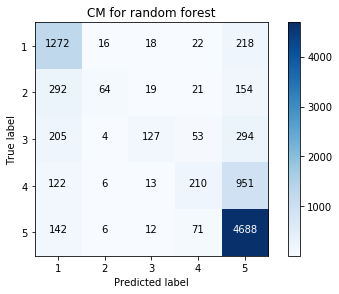

In [0]:
class_names = [1,2,3,4,5]
plt.figure()
plot_confusion_matrix(cm_randomforest
                      , classes=class_names
                      , title='CM for random forest')
plt.show()


The second model we built is the NBSVM model. NBSVM was introduced by Sida Wang and Chris Manning in the paper 'Baselines and Bigrams: Simple, Good Sentiment and Topic Classification'. In general, the Naive Bayers model performs better on short texts, and SVM performs better on long text processing. In this paper, the authors provide a new classifier that combines the traditional Naive Bayers and SVM models and experimented on different data sets, which is better than using one of the models alone. Therefore, the NBSVM model performs very well on combined text classification issues.
To use the NBSVM model, we also divide the dataset into two parts, training data and test data, with a ratio of 0.3. At the same time, we remove the punctuaions from the text by using 're' library, then extract the term frequency, vectorize it through the TfidfVectorizer library. The NBSVM model construction part is provided by lrei on github. Finally we trains model with the processed training dataset then evaluates the prediction results.

In [0]:
import pandas as pd, numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

In [0]:
#data preprocessing
data = dataset[dataset['Reviews'].isnull()==False]
train, test = train_test_split(data, test_size = 0.3)


In [0]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [0]:
review = 'Reviews'

n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[review])
test_term_doc = vec.transform(test[review])

In [0]:
#based on a work at https://github.com/lrei/nbsvm
#import NB-SVM model.

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import six
from abc import ABCMeta
import numpy as np
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

class NBSVM(six.with_metaclass(ABCMeta, BaseEstimator, ClassifierMixin)):

    def __init__(self, alpha=1.0, C=1.0, max_iter=10000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.C = C
        self.svm_ = [] # fuggly

    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        _, n_features = X.shape

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        # LabelBinarizer().fit_transform() returns arrays with dtype=np.int64.
        # so we don't have to cast X to floating point
        Y = Y.astype(np.float64)

        # Count raw events from data
        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.ratios_ = np.full((n_effective_classes, n_features), self.alpha,
                                 dtype=np.float64)
        self._compute_ratios(X, Y)

        # flugglyness
        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            svm = LinearSVC(C=self.C, max_iter=self.max_iter)
            Y_i = Y[:,i]
            svm.fit(X_i, Y_i)
            self.svm_.append(svm) 

        return self

    def predict(self, X):
        n_effective_classes = self.class_count_.shape[0]
        n_examples = X.shape[0]

        D = np.zeros((n_effective_classes, n_examples))

        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            D[i] = self.svm_[i].decision_function(X_i)
        
        return self.classes_[np.argmax(D, axis=0)]
        
    def _compute_ratios(self, X, Y):
        """Count feature occurrences and compute ratios."""
        if np.any((X.data if issparse(X) else X) < 0):
            raise ValueError("Input X must be non-negative")

        self.ratios_ += safe_sparse_dot(Y.T, X)  # ratio + feature_occurrance_c
        normalize(self.ratios_, norm='l1', axis=1, copy=False)
        row_calc = lambda r: np.log(np.divide(r, (1 - r)))
        self.ratios_ = np.apply_along_axis(row_calc, axis=1, arr=self.ratios_)
        check_array(self.ratios_)
        self.ratios_ = sparse.csr_matrix(self.ratios_)

        #p_c /= np.linalg.norm(p_c, ord=1)
        #ratios[c] = np.log(p_c / (1 - p_c))


def f1_class(pred, truth, class_val):
    n = len(truth)

    truth_class = 0
    pred_class = 0
    tp = 0

    for ii in range(0, n):
        if truth[ii] == class_val:
            truth_class += 1
            if truth[ii] == pred[ii]:
                tp += 1
                pred_class += 1
                continue;
        if pred[ii] == class_val:
            pred_class += 1

    precision = tp / float(pred_class)
    recall = tp / float(truth_class)

    return (2.0 * precision * recall) / (precision + recall)


def semeval_senti_f1(pred, truth, pos=2, neg=0): 

    f1_pos = f1_class(pred, truth, pos)
    f1_neg = f1_class(pred, truth, neg)

    return (f1_pos + f1_neg) / 2.0;


def main(train_file, test_file, ngram=(1, 3)):
    print('loading...')
    train = pd.read_csv(train_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    # to shuffle:
    #train.iloc[np.random.permutation(len(df))]

    test = pd.read_csv(test_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    print('vectorizing...')
    vect = CountVectorizer()
    classifier = NBSVM()

    # create pipeline
    clf = Pipeline([('vect', vect), ('nbsvm', classifier)])
    params = {
        'vect__token_pattern': r"\S+",
        'vect__ngram_range': ngram, 
        'vect__binary': True
    }
    clf.set_params(**params)

    #X_train = vect.fit_transform(train['text'])
    #X_test = vect.transform(test['text'])

    print('fitting...')
    clf.fit(train['text'], train['label'])

    print('classifying...')
    pred = clf.predict(test['text'])
   
    print('testing...')
    acc = accuracy_score(test['label'], pred)
    f1 = semeval_senti_f1(pred, test['label'])
    print('NBSVM: acc=%f, f1=%f' % (acc, f1))

In [0]:
#Build and train NBSVM model.
model = NBSVM(C=0.05)
model.fit( trn_term_doc, train["Rating"] )

pred = model.predict( test_term_doc )

In [0]:
print('NBSVM accuracy: ', accuracy_score(test['Rating'], pred))

NBSVM accuracy:  0.7106345149461051


In [0]:
cm_NBSVM = confusion_matrix(test['Rating'], pred)

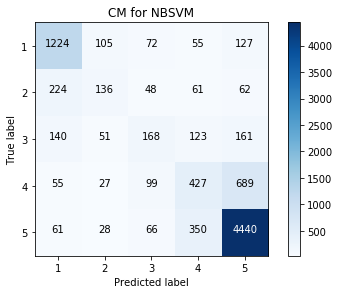

In [0]:
class_names = [1,2,3,4,5]
plt.figure()
plot_confusion_matrix(cm_NBSVM 
                      , classes=class_names
                      , title='CM for NBSVM')
plt.show()

The third model we built is the LSTM model. The LSTM model is a special RNN model. The traditional RNN model has long-term dependency problems when predicting long texts, that is, it cannot learn information which is far apart. The LSTM model internally adds filters to the information transmitted from the previous node, thus retains important information and 'forgets' unimportant information, in order to solve the problem of gradient disappearance and gradient explosion in long sequence training. It has a better performance in long sequence. 

We use the 'keras' library to build the LSTM model. First, the dataset is divided into training samples and test samples according to the ratio of 0.3. Then the 'tokenizer' function is used to convert the text data into a sequence, and then the 'pad_sequences' function is used to fill the converted sequence to the same length and convert them to a binary matrix.

In the process of model construction, we added different layers to the LSTM model, including the processed matrix, the LSTM loop layer composed of storage units, the dense layer which is used to output the predicted attached an activation function suitable for the multi-class model. Then, the model was compiled with the loss function, optimization algorithm, metrics and other parameters. Finally, we use the train dataset to train the model and the prediction results were evaluated.





In [0]:
#implement LSTM model
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Activation


Using TensorFlow backend.


In [0]:
#set parameters to accelerate the model
max_words = 30000
maxlength = 80
batch_size = 32
classes = 6

In [0]:
#split dataset into train and test dataset
data = dataset[dataset['Reviews'].isnull()==False]
train, test = train_test_split(data, test_size = 0.3)
tokenizer = Tokenizer(nb_words=max_words)
tokenizer.fit_on_texts(train['Reviews'])
sequences_train = tokenizer.texts_to_sequences(train['Reviews'])
sequences_test = tokenizer.texts_to_sequences(test['Reviews'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning:

The `nb_words` argument in `Tokenizer` has been renamed `num_words`.



In [0]:
#data preprocessing
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlength)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlength)
y_train = np.array(train['Rating']-1)
y_test = np.array(test['Rating']-1)
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (20995, 80)
X_test shape: (8999, 80)


In [0]:

print('Build model: ')
model = Sequential()
model.add(Embedding(max_words, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model.add(Dense(classes))
model.add(Activation('softmax')) #muti-classifier

model.compile(loss='binary_crossentropy', #loss function
              optimizer='adam',  #improve algorithm
              metrics=['accuracy']) #metrics



Build model: 




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         3840000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
_________________________________________________________________
activation_1 (Activation)    (None, 6)                 0         
Total params: 3,972,358
Trainable params: 3,972,358
Non-trainable params: 0
_________________________________________________________________


In [0]:
print('Train LSTM nural network: ')

history = model.fit(X_train, Y_train, batch_size=32, nb_epoch=5, validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
preds = model.predict_classes(X_test, verbose=0)

Train LSTM nural network: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 20995 samples, validate on 8999 samples
Epoch 1/5
20995/20995 [==============================] - 118s 6ms/step - loss: 0.2737 - acc: 0.8912 - val_loss: 0.2599 - val_acc: 0.8980
Epoch 2/5
20995/20995 [==============================] - 122s 6ms/step - loss: 0.2179 - acc: 0.9132 - val_loss: 0.2375 - val_acc: 0.9064
Epoch 3/5
20995/20995 [==============================] - 114s 5ms/step - loss: 0.1931 - acc: 0.9226 - val_loss: 0.2377 - val_acc: 0.9078
Epoch 4/5
20995/20995 [==============================] - 111s 5ms/step - loss: 0.1716 - acc: 0.9320 - val_loss: 0.2550 - val_acc: 0.9043
Epoch 5/5
8999/8999 [==============================] - 6s 637us/step
Test score: 0.27268683561147194
Test accuracy: 0.9048412893332167


In [0]:
# evaluate the prediction result
print('LTSM accuracy: ', accuracy_score(test['Rating'], preds+1))

LTSM accuracy:  0.697521946882987


In [0]:
cm_LSTM = confusion_matrix(test['Rating'], preds+1)


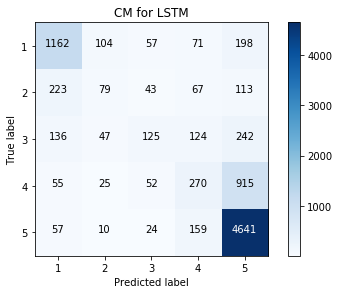

In [0]:
class_names = [1,2,3,4,5]
plt.figure()
plot_confusion_matrix(cm_LSTM
                      , classes=class_names
                      , title='CM for LSTM')
plt.show()

# Evaluation

After completing the training of the model, we input the dataset used for testing into the three models and obtain the predicted results. We use the 'accuracy' library to compare the predicted results with the real results, and visualize it. It can be seen from the above scores that the test results of the three models are similar, 0.706 for random forest, 0.71 for NBSVM and 0.697, respectively. At the same time, we also adjusted the parameters for each model. In the random forest model, we tested the number of different decision trees and finally selected 100 as a parameter. In the NBSVM model, we tested different penalty function C values and finally selected 0.05 as the penalty parameter. In the LSTM model, we tried to increase the epoch times, select different loss function and optimization algorithm, finally we chose the above parameters. If the epoch number is too large, it will lead to over-fitting, so we finally choose 5 as epoch number.

In terms of the efficiency of the model, when the random forest is set to 100 trees, the model construction speed is slower. The fastest training among the three models is the NVSVM model. The construction speed are related to the parameters of the iteration and number of layers of the LSTM model. However, if the number of iterations is too large, it will lead to over-fitting.


# Conclusion

From the three graphs of the model prediction visualizations, we can see that the classification of 1 point and 5 points is mostly correct, because the corresponding consumers' attitudes and emotions are more obvious. At the same time, most of the false predictions appear between 4 points and 5 points. Considering the data set, it may be because the text reviews given by customers who scored 4 points and 5 points are similar, mostly positive reviews.

From the accuracy score perspective, the performance of the three models is comparable. It can be seen that all three models have the ability to deal with classification problems of reviews which mixed long and short texts.

Combined with the dataset, many customers have given high scores but may not have very positive feedback in the comments, vise versa. This part of the data will affect the accuracy of the model. In the data preprocessing section, if we can remove this part of the data training model, we may get more accurate prediction results.

# Ethical
Using machine learning to establish a natural language analysis model for automatic analysis and classification of user comments on shopping websites is just a small branch of language analysis using machine learning. Its technology can be applied to many other fields, providing great convenience for social and economic activities. But if its application is not well regulated and limited, it may also bring some ethical issues. Below we will use the utilitarian approach to analyse it specifically.
Firstly, we need to identify the relevant stakeholders. Automatic analysis of user comments on shopping sites can have an impact on customers, sellers, shopping sites, and manufacturers. For sellers and commodity manufacturers, the natural language analysis model can help them deal with a large number of user reviews, save time and effort, and get the feedback they need to adjust the sales strategy in a targeted manner. For shopping websites, the natural language analysis model enables them to understand the needs of users better and make more personalized recommendations for users, thus achieving greater economic benefits. For customers, on the one hand, their feedback can be received more quickly and efficiently by the seller. But on the other hand, the processing of the machine can only simply classify the comments, and cannot understand the real needs of customers.  Moreover, to some extent, if natural language analysis is applied to all aspects of people's lives, then people's daily communication will be analysed by machine analysis. The machine extracts useful information from people's daily emails and texts, which is a big threat to the privacy of personal privacy. In short, in addition to potentially threatening people's privacy, natural language analysis models can provide people with a lot of convenience. Therefore, we must develop certain limits on its application while ensuring that it does not infringe on personal privacy.
